# Imports

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import lime.lime_tabular
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from SyntheticDataset import SyntheticDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PerformanceAnalysis import PerformanceAnalysis
from Visualization import Visualization

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Setup

In [2]:
config_file = open('config.json')
config_vars = json.load(config_file)
config_file.close()

logs_dir = config_vars["logs_dir"]

In [3]:
config_file = open('visual_config.json')
config_vars = json.load(config_file)
config_file.close()

shap_colors_neg = config_vars["shap_colors"]["negative"]
shap_colors_pos = config_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = config_vars["title_font_size"]
label_size = config_vars["labels_font_size"]

# Binary Classification

## Create the Dataset

In [4]:
perf_analysis = PerformanceAnalysis()

min_val = -100
max_val = 100
num_rows = 1000
num_features = 10
num_classes = 2
rand_coef = [[0.95, 0.95],
             [0.9, 0.9],
             [0.85, 0.85],
             [0.8, 0.8],
             [0.75, 0.75],
             [0.7, 0.7],
             [0.65, 0.65],
             [0.6, 0.6],
             [0.55, 0.55],
             [0.5, 0.5]]
features_names = ["Var" + (str(x)) for x in range(num_features)]
dataset = SyntheticDataset(min_val, max_val, num_rows, num_features, num_classes, rand_coef, seed=42)
dataset.generate()
dataset.get_data()

array([[  54.79120971,  -12.22431205, -100.        , ...,  -74.37727346,
        -100.        ,    0.        ],
       [  85.35299777,   28.77302402,   64.55232265, ...,   26.33287982,
        -100.        ,    0.        ],
       [  94.13960488, -100.        , -100.        , ...,   48.95243118,
        -100.        ,    0.        ],
       ...,
       [  88.8442307 ,   20.57826467,  -19.07427551, ...,  -44.15947746,
         100.        ,    1.        ],
       [ 100.        ,   15.64802699,  100.        , ...,  -76.40459578,
          99.77433795,    1.        ],
       [  79.20966309,   21.83719075,   43.01403336, ...,  100.        ,
           8.60805167,    1.        ]])

## Split the Dataset

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(
    dataset.get_x(), dataset.get_y(), test_size=0.20, shuffle=True, stratify=dataset.get_y(), random_state=42)

Y_train = [int(x) for x in Y_train]
Y_test = [int(x) for x in Y_test]

cross_val = StratifiedKFold(n_splits=5)

X_train_pd = pd.DataFrame(X_train, columns=features_names)
X_test_pd = pd.DataFrame(X_test, columns=features_names)

#### Instance to extract local explanations for all models

In [6]:
Exp_index = 3
Exp_inst = X_test[Exp_index, :]
Exp_inst_pd = X_test_pd.iloc[Exp_index, :]
Exp_inst_class = Y_test[Exp_index]
print(f"Instance:\n{Exp_inst_pd}\n\nClass: {Exp_inst_class}") #"Name" and "dtype" are not part of the instance, they must be ignored

Instance:
Var0    -98.537109
Var1    -44.395579
Var2     40.606693
Var3   -100.000000
Var4     96.361190
Var5     24.071542
Var6     -4.498825
Var7     52.286513
Var8     80.665574
Var9   -100.000000
Name: 3, dtype: float64

Class: 0


# Classification

## <i>Logistic Regression</i> (LR)

In [7]:
param_grid = {"max_iter": [100, 500, 1000, 2000],
              "solver": ["lbfgs", "liblinear", "newton-cholesky"], 
              "C": [0.01, 0.1, 1, 10, 100]}

lr_grid = GridSearchCV(LogisticRegression(random_state=42), param_grid, refit="accuracy", verbose=3, n_jobs=-1, cv=cross_val,scoring=["accuracy", "recall"])
   
lr_init_t = time.time()
lr_grid.fit(X_train, Y_train)
lr_fin_t = time.time()

lr_duration = lr_fin_t - lr_init_t

print(f"{lr_duration} segundos")
 
print(lr_grid.best_params_)
print(f"Best Score: {lr_grid.best_score_}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
3.0729429721832275 segundos
{'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}
Best Score: 0.92875


In [8]:
lr_clf = lr_grid.best_estimator_

In [9]:
lr_clf.predict([Exp_inst])

array([0])

Metrics                Values
accuracy             0.955000
false-positive rate  0.040000
false-negative rate  0.050000
precision            0.959596
recall               0.950000
f-score              0.954774

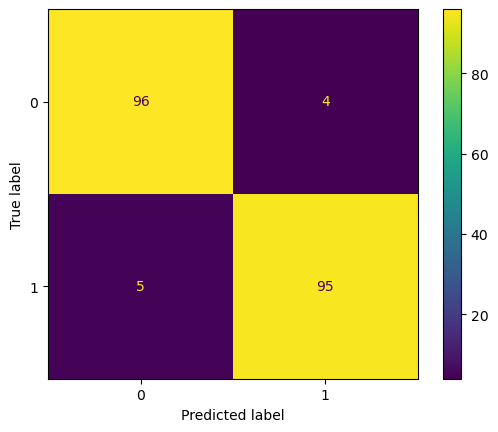

In [10]:
lr_ye = lr_clf.predict(X_test)

lr_cm = confusion_matrix(Y_test, lr_ye)
lr_metrics = perf_analysis.compute_metrics(lr_cm)
display(lr_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, lr_ye)

lr_y2d = lr_clf.predict_proba(X_test)[:, 1]

plt.show()

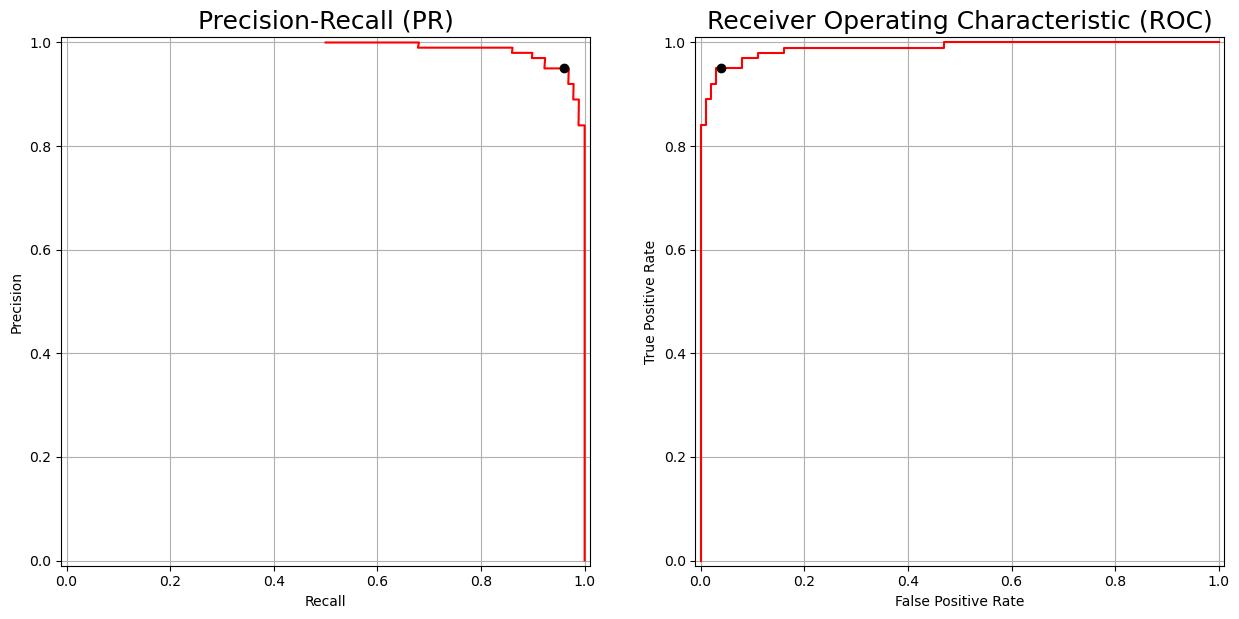

In [11]:
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
perf_analysis.plot_PR(Y_test, lr_cm, lr_y2d)
plt.subplot(1,2,2)
perf_analysis.plot_ROC(Y_test, lr_cm, lr_y2d)

plt.show()

### Extract Explanations

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [12]:
lr_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, random_state=42)
lr_LIME_explanation = lr_LIME_explainer.explain_instance(Exp_inst, lr_clf.predict_proba)

In [13]:
lr_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [14]:
shap.initjs()

In [15]:
lr_shap_init = time.time()
lr_SHAP_exp = shap.KernelExplainer(lr_clf.predict_proba, shap.sample(X_train_pd, 20, random_state=42), random_state=42)
lr_shap_loc_values = np.array(lr_SHAP_exp.shap_values(Exp_inst_pd))

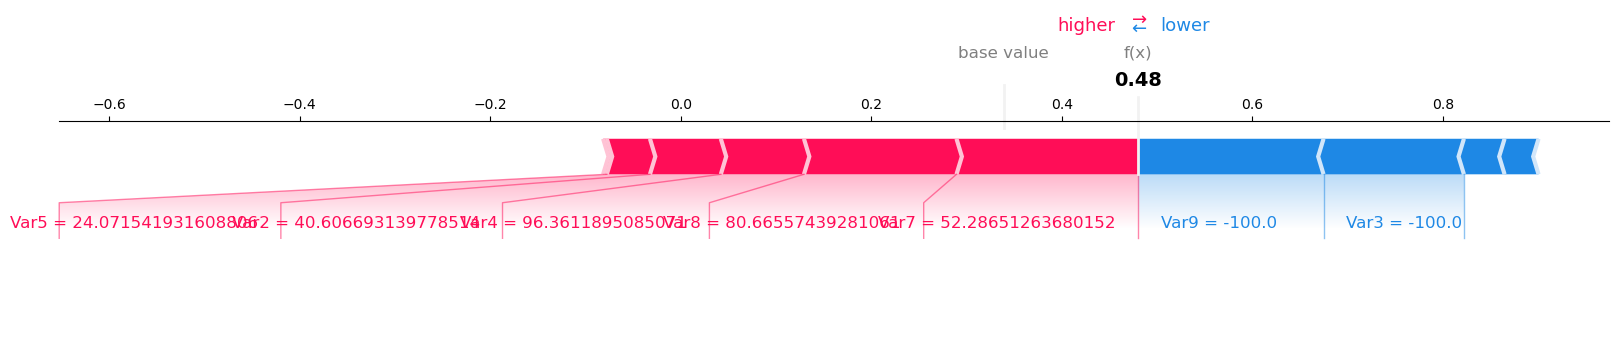

In [16]:
shap.force_plot(lr_SHAP_exp.expected_value[1], lr_shap_loc_values[1, :], Exp_inst_pd, matplotlib=True)

#### Global (SHAP)

In [17]:
lr_shap_global_values = lr_SHAP_exp.shap_values(X_test_pd)
lr_shap_fin = time.time()
lr_shap_dur = lr_shap_fin - lr_shap_init

  0%|          | 0/200 [00:00<?, ?it/s]

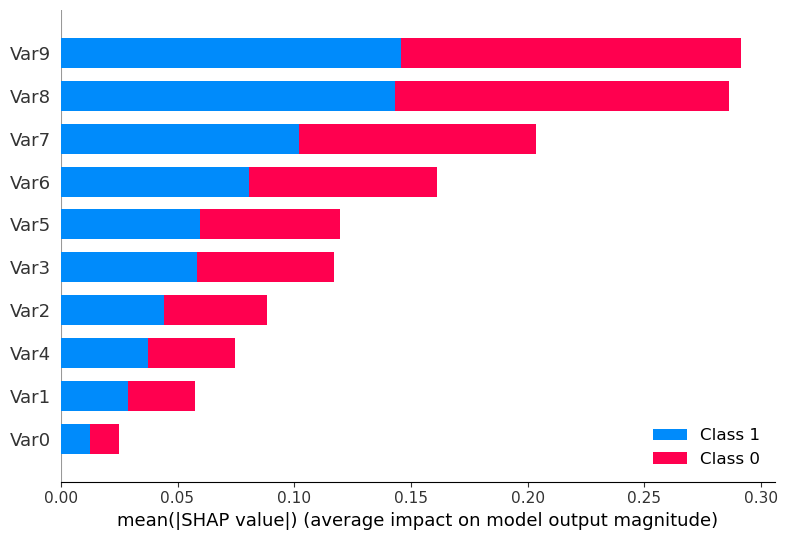

In [18]:
shap.summary_plot(lr_shap_global_values, X_test_pd, plot_type="bar")

## <i>Random Forest</i> (RF)

In [19]:
param_grid = {"n_estimators": [100, 250, 500, 1000, 2000],
              "bootstrap": [True, False],
              "max_features": ["sqrt", "log2", None]}
   
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, refit="accuracy", verbose=3, cv=cross_val, n_jobs=-1, scoring=["accuracy", "recall"]) 
   
rf_init_t = time.time() 
rf_grid.fit(X_train, Y_train) 
rf_fin_t = time.time()

rf_duration = rf_fin_t - rf_init_t

print(f"{rf_duration} segundos")
 
print(rf_grid.best_params_)
print(f"Best Score: {rf_grid.best_score_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
47.07843041419983 segundos
{'bootstrap': False, 'max_features': 'sqrt', 'n_estimators': 1000}
Best Score: 0.98375


In [20]:
rf_clf = rf_grid.best_estimator_

In [21]:
rf_clf.predict([Exp_inst])

array([0])

Metrics                Values
accuracy             0.985000
false-positive rate  0.010000
false-negative rate  0.020000
precision            0.989899
recall               0.980000
f-score              0.984925

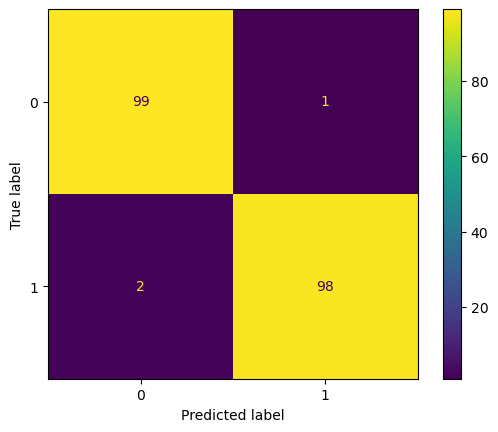

In [22]:
rf_ye = rf_clf.predict(X_test)

rf_cm = confusion_matrix(Y_test, rf_ye)
rf_metrics = perf_analysis.compute_metrics(rf_cm)
display(rf_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, rf_ye)

rf_y2d = rf_clf.predict_proba(X_test)[:, 1]

plt.show()

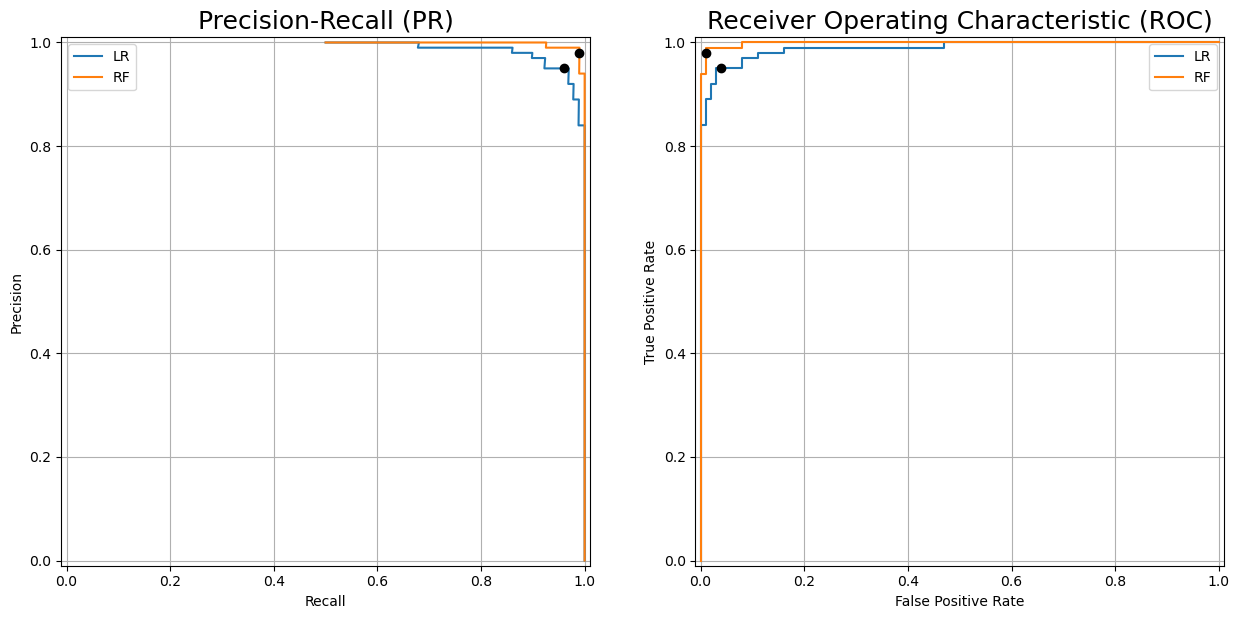

In [23]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR", "RF"])

plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR","RF"])


plt.show()

### Extract Explanations 

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [24]:
rf_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, random_state=42)
rf_LIME_explanation = rf_LIME_explainer.explain_instance(Exp_inst, rf_clf.predict_proba)

In [25]:
rf_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [26]:
rf_shap_init = time.time()
rf_SHAP_exp = shap.TreeExplainer(rf_clf, random_state=42)
rf_shap_loc_values = np.array(rf_SHAP_exp.shap_values(Exp_inst_pd))

In [27]:
shap.force_plot(rf_SHAP_exp.expected_value[1], rf_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)

In [28]:
rf_shap_global_values = rf_SHAP_exp.shap_values(X_test_pd)
rf_shap_fin = time.time()
rf_shap_dur = rf_shap_fin - rf_shap_init

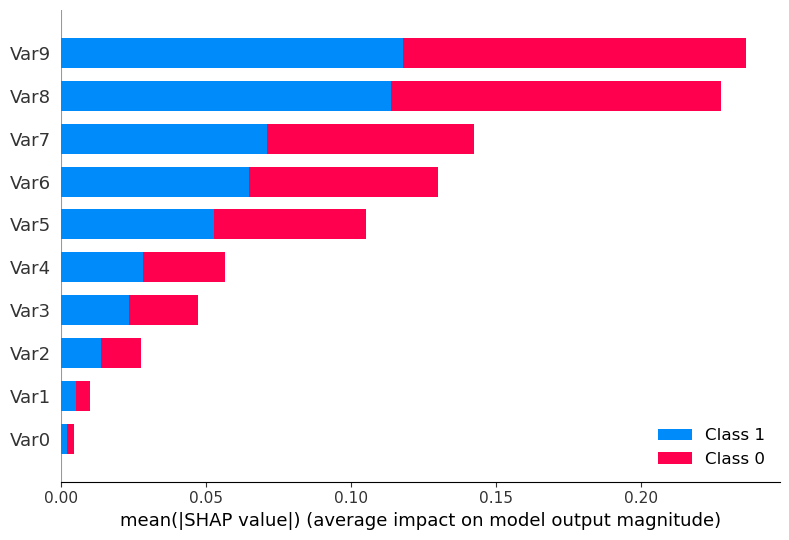

In [29]:
shap.summary_plot(rf_shap_global_values, X_test_pd, plot_type="bar")

## <i> Support Vector Machines</i> (SVM)

In [30]:
param_grid = {"kernel": ["rbf", "linear"],
              "C": [0.05, 0.1, 1, 10, 100, 500]}
   
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), param_grid, refit="accuracy", verbose=3, n_jobs=-1, cv=cross_val, scoring=["accuracy", "recall"])
   
svm_init_t = time.time()
svm_grid.fit(X_train, Y_train)
svm_fin_t = time.time()

svm_duration = svm_fin_t - svm_init_t

print(f"{svm_duration} segundos")
 
# print best parameter after tuning 
print(svm_grid.best_params_)
print(f"Best Score: {svm_grid.best_score_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
10816.286532878876 segundos
{'C': 0.1, 'kernel': 'rbf'}
Best Score: 0.9299999999999999


In [31]:
svm_clf = svm_grid.best_estimator_

In [32]:
svm_clf.predict([Exp_inst])

array([1])

Metrics                Values
accuracy             0.940000
false-positive rate  0.080000
false-negative rate  0.040000
precision            0.923077
recall               0.960000
f-score              0.941176

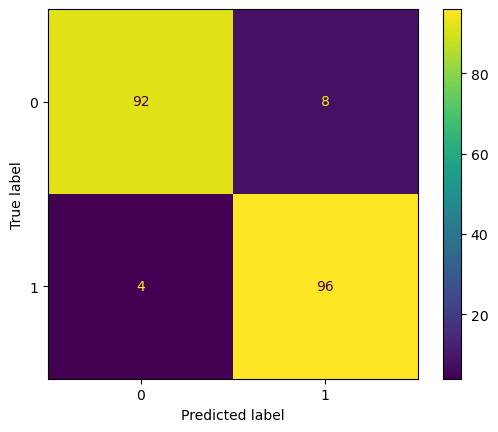

In [33]:
svm_ye = svm_clf.predict(X_test)

svm_cm = confusion_matrix(Y_test, svm_ye)
svm_metrics = perf_analysis.compute_metrics(svm_cm)
display(svm_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, svm_ye)

svm_y2d = svm_clf.decision_function(X_test)

plt.show()

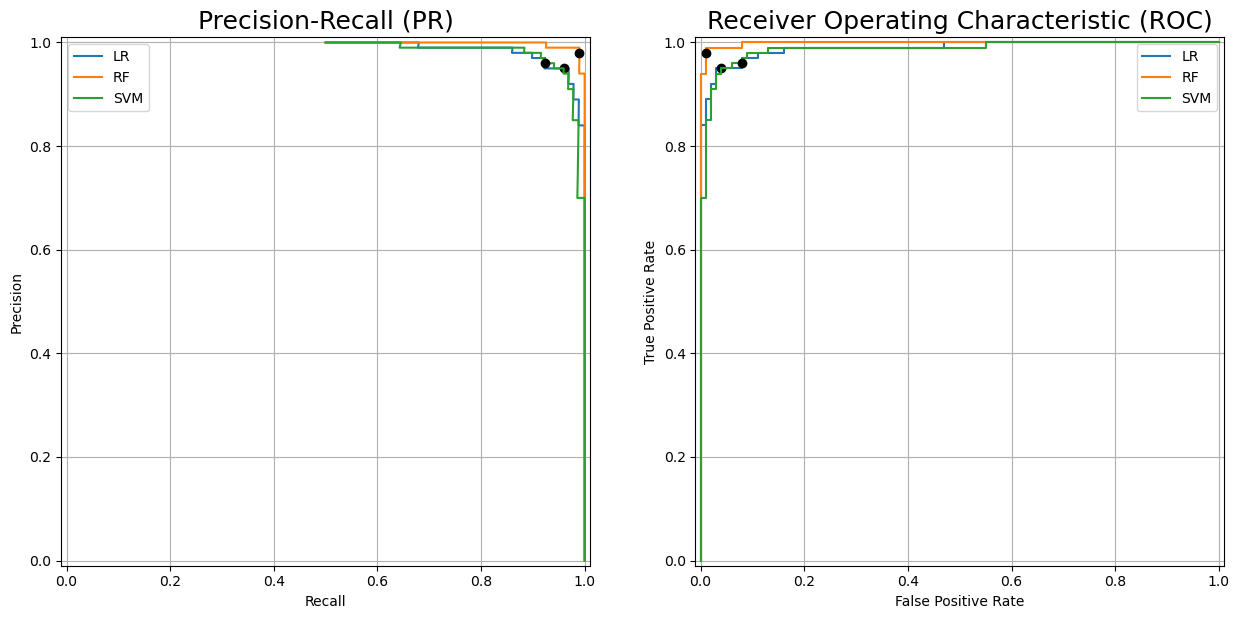

In [34]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR", "RF", "SVM"])
plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR","RF", "SVM"])

plt.show()

### Extract Explanations

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [35]:
svm_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, random_state=42)
svm_LIME_explanation = svm_LIME_explainer.explain_instance(Exp_inst, svm_clf.predict_proba)

In [36]:
svm_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [37]:
svm_shap_init = time.time()
svm_SHAP_exp = shap.KernelExplainer(svm_clf.predict_proba, shap.sample(X_train_pd, 20, random_state=42), random_state=42)
svm_shap_loc_values = np.array(svm_SHAP_exp.shap_values(Exp_inst_pd))

In [38]:
shap.force_plot(svm_SHAP_exp.expected_value[1], svm_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)

In [39]:
svm_shap_global_values = svm_SHAP_exp.shap_values(X_test_pd)
svm_shap_fin = time.time()
svm_shap_dur = svm_shap_fin - svm_shap_init

  0%|          | 0/200 [00:00<?, ?it/s]

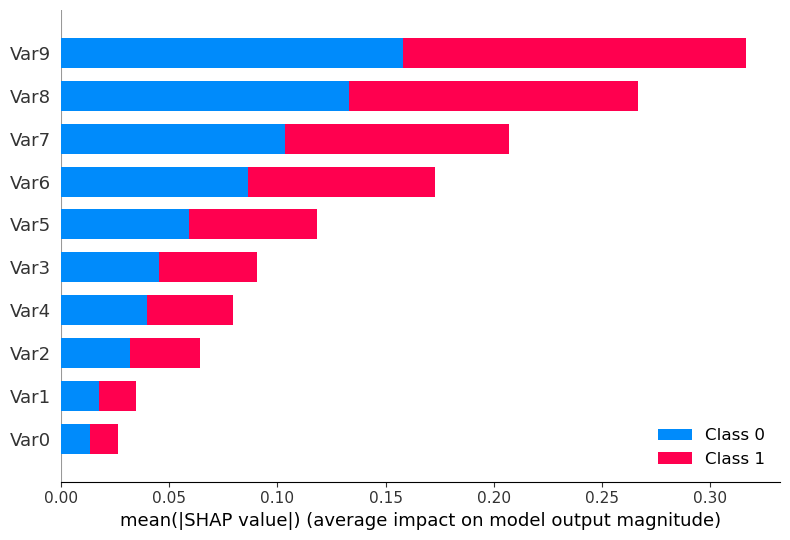

In [40]:
shap.summary_plot(svm_shap_global_values, X_test_pd, plot_type="bar")

## <i>Explainable Boosting Machine</i> (EBM)

In [41]:
param_grid = {"smoothing_rounds": [500, 1000], 
              "cyclic_progress": [0, 0.5], 
              "max_bins": [ 1024, 2048]} 

# (probability=True) gives the possibility to use the predict_proba() method, which is used to extract explanations
ebm_grid = GridSearchCV(ExplainableBoostingClassifier(random_state=42), param_grid, refit="accuracy", verbose=3, n_jobs=-1, cv=cross_val, scoring=["accuracy", "recall"]) 

ebm_init_t = time.time() 
ebm_grid.fit(X_train_pd, Y_train) 
ebm_fin_t = time.time() 

ebm_duration = ebm_fin_t - ebm_init_t

print(f"{ebm_duration} segundos")

print(ebm_grid.best_params_)
print(f"Best Score: {ebm_grid.best_score_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
123.26386880874634 segundos
{'cyclic_progress': 0, 'max_bins': 1024, 'smoothing_rounds': 1000}
Best Score: 0.98375


In [42]:
ebm_clf = ebm_grid.best_estimator_

In [43]:
ebm_clf.predict([Exp_inst])

array([0], dtype=int64)

Metrics              Values
accuracy               0.98
false-positive rate    0.02
false-negative rate    0.02
precision              0.98
recall                 0.98
f-score                0.98

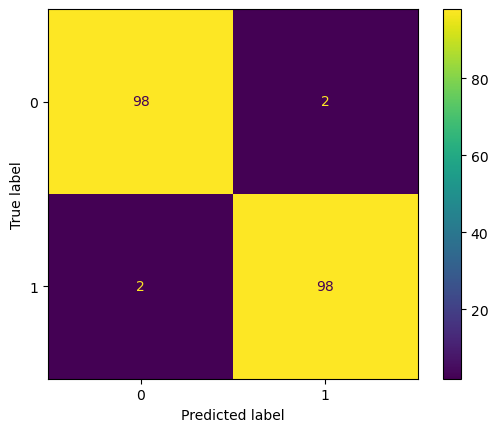

In [44]:
ebm_ye = ebm_clf.predict(X_test)

ebm_cm = confusion_matrix(Y_test, ebm_ye)
ebm_metrics = perf_analysis.compute_metrics(ebm_cm)
display(ebm_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, ebm_ye)

ebm_y2d = ebm_clf.decision_function(X_test)

plt.show()

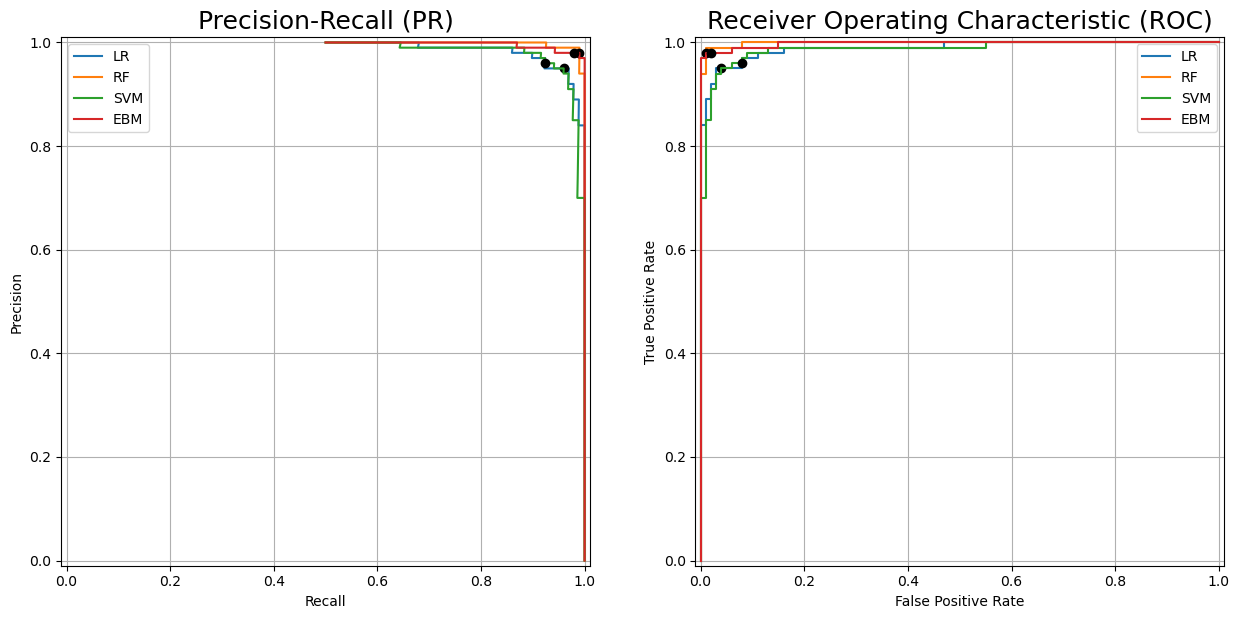

In [45]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR", "RF", "SVM", "EBM"])
plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR","RF", "SVM", "EBM"])

plt.show()

### Extract Explanations

#### Local

In [46]:
ebm_local = ebm_clf.explain_local(X_test, Y_test)
show(ebm_local)

<!-- http://127.0.0.1:7001/1987656539216/ -->

#### Global

In [47]:
ebm_global = ebm_clf.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/1987603521296/ -->

# Summary

In [48]:
visual = Visualization()

## Time

In [49]:
time_pd_cols = ["LR", "RF", "SVM", "EBM"]
fit_durs = [round(x, 1) for x in [lr_duration, rf_duration, svm_duration, ebm_duration]]
shap_durs = [round(x, 1) for x in [lr_shap_dur, rf_shap_dur, svm_shap_dur]]
pd_vals = [fit_durs, shap_durs]

duration_summary = pd.DataFrame(pd_vals, columns=time_pd_cols, index=["Fit", "SHAP"])
duration_summary.columns.names = ["Task"]
duration_summary

Task    LR    RF      SVM    EBM
Fit    3.1  47.1  10816.3  123.3
SHAP  25.7   2.4    217.8    NaN

In [50]:
latex_str = duration_summary.columns.name + "".join([" & " + x for x in duration_summary.columns]) + " \\\ \n"
for i, row in duration_summary.iterrows():

    aux_str = i
    for k in row:
        aux_str += f" & {k}"

    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/synth_bin_duration.txt", "w") as text_file:
    print(latex_str, file=text_file)

## Metrics

In [51]:
lr_metrics = lr_metrics.rename(columns={"Values": "LR"})
lr_metrics["LR"] = [round(x, 2) for x in lr_metrics["LR"]]
rf_metrics = rf_metrics.rename(columns={"Values": "RF"})
rf_metrics["RF"] = [round(x, 2) for x in rf_metrics["RF"]]
svm_metrics = svm_metrics.rename(columns={"Values": "SVM"})
svm_metrics["SVM"] = [round(x, 2) for x in svm_metrics["SVM"]]
ebm_metrics = ebm_metrics.rename(columns={"Values": "EBM"})
ebm_metrics["EBM"] = [round(x, 2) for x in ebm_metrics["EBM"]]

overall_metrics = pd.concat([lr_metrics, rf_metrics, svm_metrics, ebm_metrics], axis=1)
display(overall_metrics)

Metrics                LR    RF   SVM   EBM
accuracy             0.95  0.98  0.94  0.98
false-positive rate  0.04  0.01  0.08  0.02
false-negative rate  0.05  0.02  0.04  0.02
precision            0.96  0.99  0.92  0.98
recall               0.95  0.98  0.96  0.98
f-score              0.95  0.98  0.94  0.98

In [52]:
latex_str = overall_metrics.columns.name  + ''.join([" & " + x for x in overall_metrics.columns]) + " \\\ \n"

In [53]:
for i, row in overall_metrics.iterrows():
    
    aux_str = i
    for k in row:
        aux_str += f" & {k}"

    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/synth_bin_metrics.txt", "w") as text_file:
    print(latex_str, file=text_file)

## Confusion Matrices

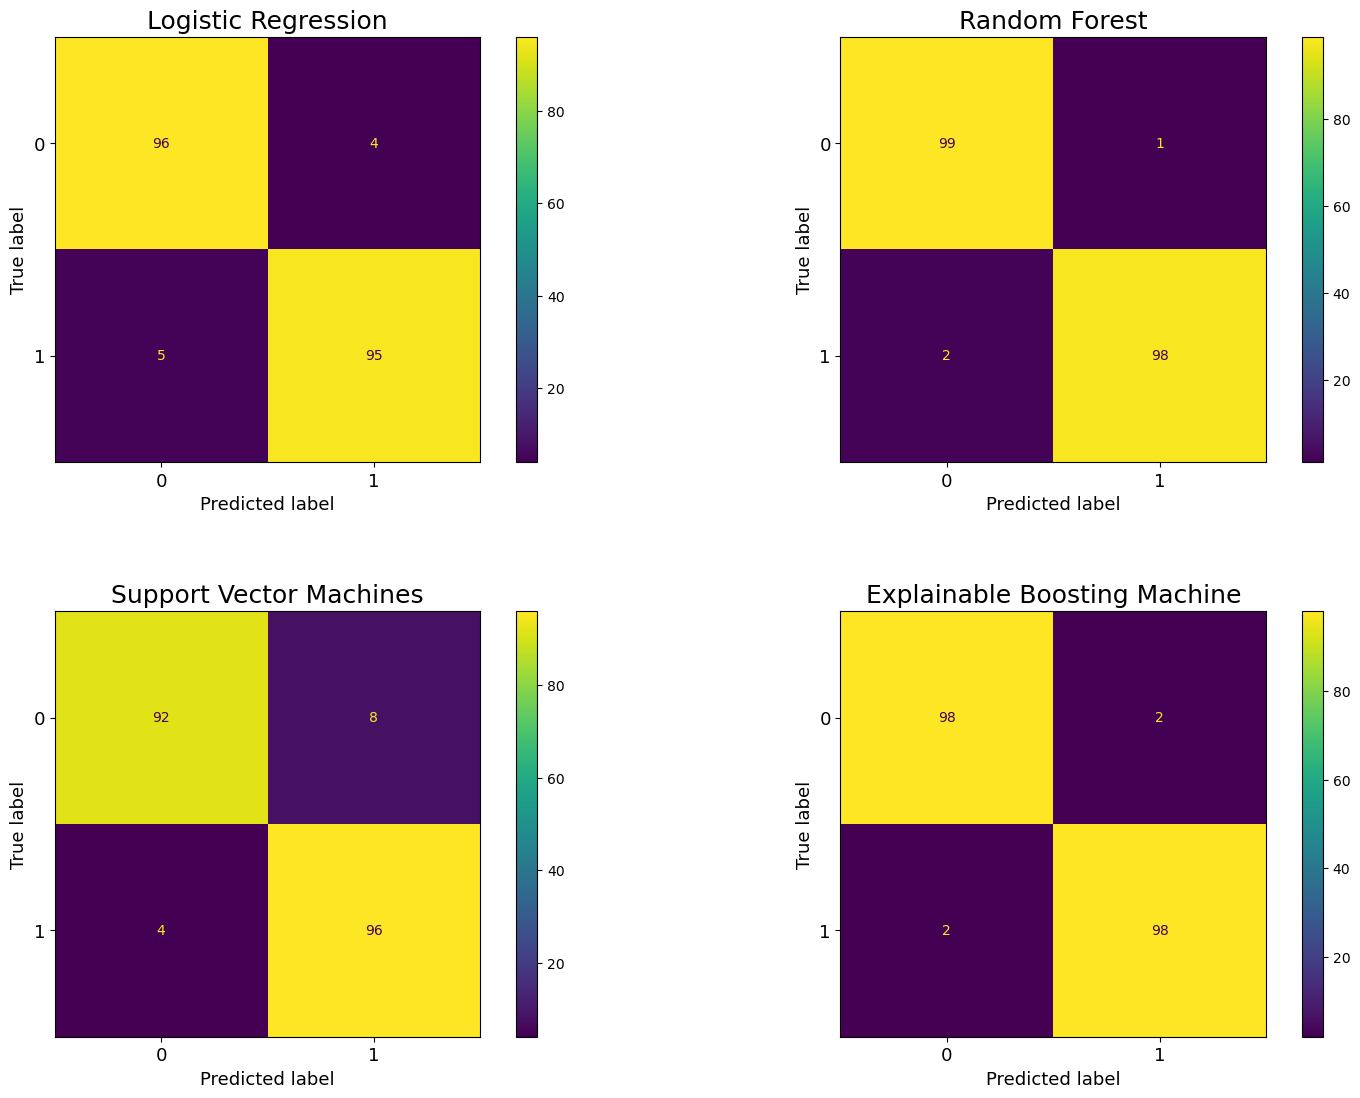

In [54]:
visual.confusion_matrices([Y_test, Y_test, Y_test, Y_test],
                          [lr_ye, rf_ye, svm_ye, ebm_ye],
                          nrows=2, 
                          ncols=2, 
                          figsize=(15,10),
                          title_size=title_size,
                          label_size=label_size,
                          titles=["Logistic Regression", "Random Forest", "Support Vector Machines", "Explainable Boosting Machine"])

plt.savefig(f"{logs_dir}/synth_bin_conf_matrices.png", bbox_inches="tight")

plt.show()

## Curves

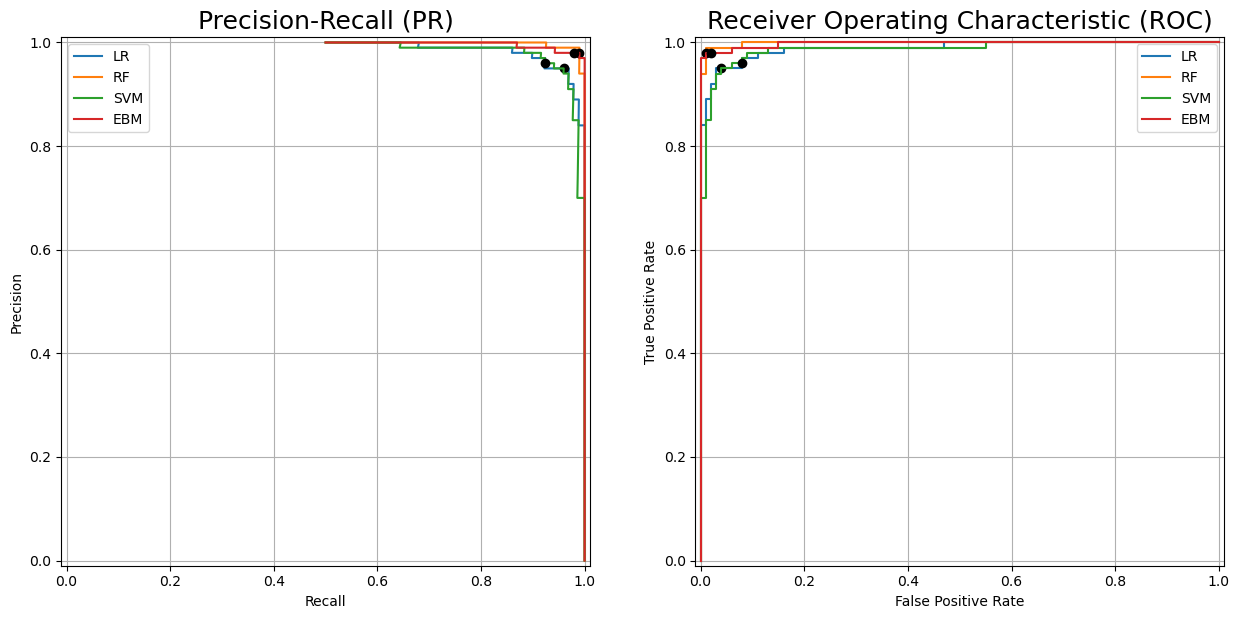

In [55]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR", "RF", "SVM", "EBM"])
plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR","RF", "SVM", "EBM"])

plt.savefig(f"{logs_dir}/synth_bin_PR_ROC.png", bbox_inches="tight")
plt.show()

## Local Explanations

### LIME

In [56]:
lr_LIME_explanation.show_in_notebook(show_table=True)
lr_LIME_explanation.save_to_file(f"{logs_dir}/synth_bin_LR_LIME.html")

In [57]:
rf_LIME_explanation.show_in_notebook(show_table=True)
rf_LIME_explanation.save_to_file(f"{logs_dir}/synth_bin_RF_LIME.html")

In [58]:
svm_LIME_explanation.show_in_notebook(show_table=True)
svm_LIME_explanation.save_to_file(f"{logs_dir}/synth_bin_SVM_LIME.html")

### SHAP & EBM

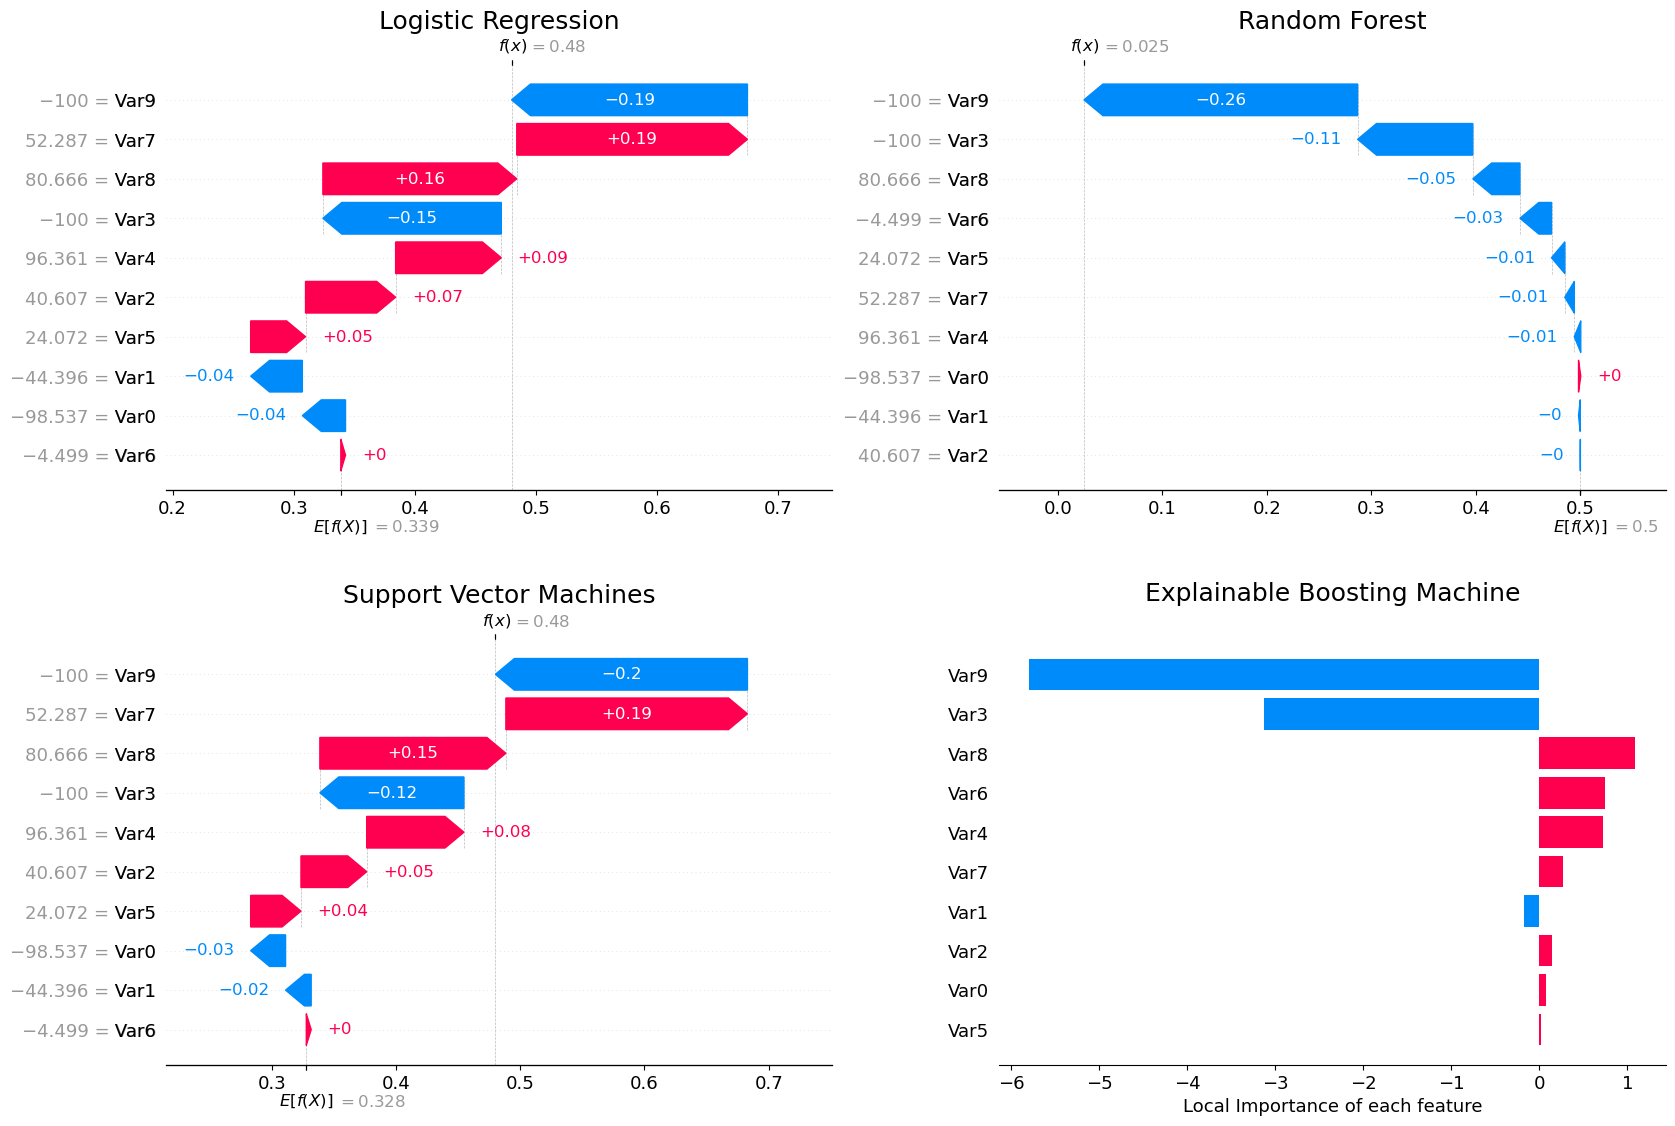

In [59]:
explanations = [shap.Explanation(lr_shap_loc_values[1, :], lr_SHAP_exp.expected_value[1], data=Exp_inst_pd),
                shap.Explanation(rf_shap_loc_values[1, :], rf_SHAP_exp.expected_value[1], data=Exp_inst_pd),
                shap.Explanation(svm_shap_loc_values[1, :], svm_SHAP_exp.expected_value[1], data=Exp_inst_pd)]


visual.local_shap(explanations, 
                  ebm_local.data(key=Exp_index),
                  nrows = 2,
                  ncols = 2,
                  figsize = (15,10),
                  title_size = title_size,
                  label_size = label_size,
                  titles = ["Logistic Regression", "Random Forest", "Support Vector Machines"],
                  ebm_colors = shap_colors/255)

plt.savefig(f"{logs_dir}/synth_bin_local_SHAP_EBM.png", bbox_inches="tight")

plt.show()


## Global Explanations

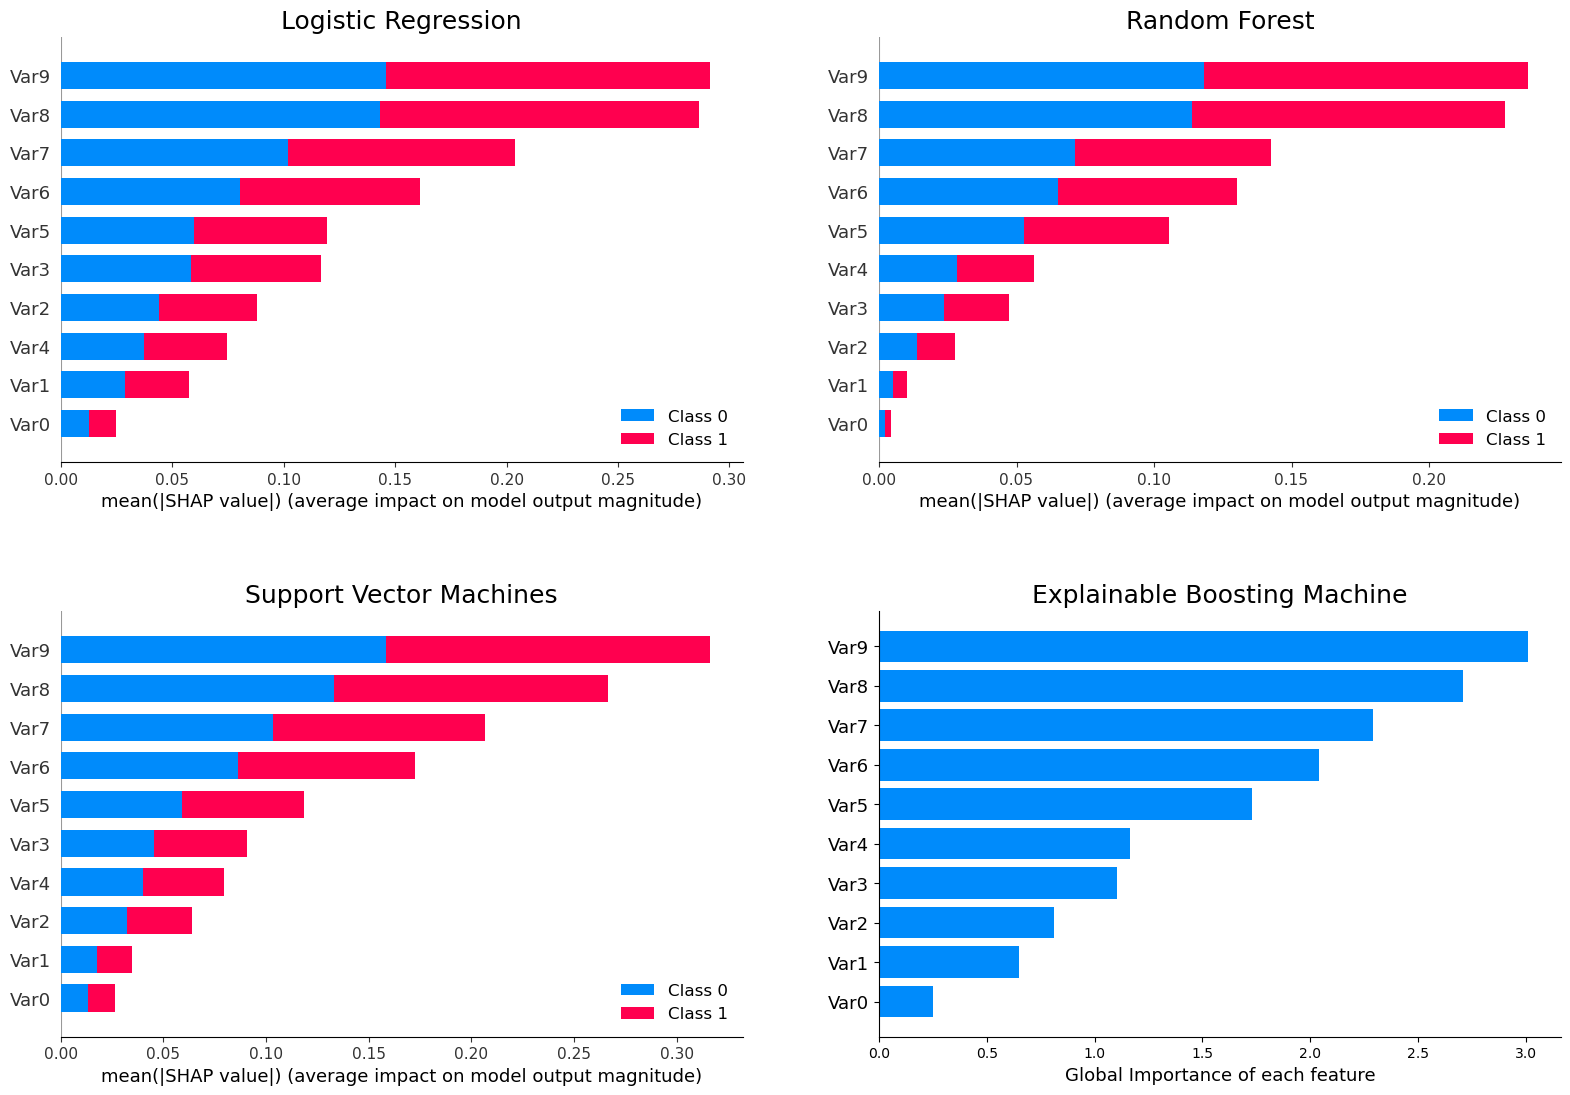

In [60]:
global_shap_values = [lr_shap_global_values,
                      rf_shap_global_values,
                      svm_shap_global_values]

visual.global_shap(global_shap_values,
                X_test_pd,
                  ebm_global.data(),
                  nrows = 2,
                  ncols = 2,
                  figsize = (15,10),
                  title_size = title_size,
                  label_size = label_size,
                  titles = ["Logistic Regression", "Random Forest", "Support Vector Machines"],
                  ebm_colors = shap_colors/255)

plt.savefig(f"{logs_dir}/synth_bin_global_SHAP_EBM.png", bbox_inches="tight")

plt.show()